## El proposito de este jupyter es obtener la version reducida de los datos y filtrada en base de la zona de estudio. 

In [28]:
#librerias necesarias
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

#Con esta libreria nos ahorramos que se muestren los warnings
import warnings
warnings.filterwarnings("ignore")

In [17]:
#dataset de los datos de cada local de nueva york
metadata = pd.read_json('meta-New_York.json.gz', lines=True, compression='gzip')

In [18]:
metadata.shape

(272189, 15)

In [19]:
metadata.isna().sum()

name                     2
address               2732
gmap_id                  0
description         217696
latitude                 0
longitude                0
category              1013
avg_rating               0
num_of_reviews           0
price               213559
hours                58077
MISC                 53773
state                77249
relative_results     19928
url                      0
dtype: int64

Vemos que hay bastantes valores nulos y columnas que no vamos a usar. Finalmente decidimos en hacer la recomendacion basada en ratings y categorias por lo que las demas columnas se pueden eliminar. Tambien no nos importa la direccion ya que usaremos las coordenadas exactas.

In [20]:
#dropear los valores nulos primero que todo
metadata.dropna(subset=['category', 'name'], inplace=True)

#y ahora dropeamos las columnas que no usaremos en ningun modelo
metadata.drop(columns=['description', 'address', 'price', 'hours', 'MISC', 'state', 'relative_results', 'url'], inplace=True)

#hay que asegurar que no hayan restaurantes duplicados
metadata.drop_duplicates(subset=['gmap_id'], inplace=True)

In [21]:
metadata.isna().sum()

name              0
gmap_id           0
latitude          0
longitude         0
category          0
avg_rating        0
num_of_reviews    0
dtype: int64

Ahora no tenemos ningun valor nulo y un dataset mas preciso.

In [22]:
metadata.shape

(269716, 7)

In [23]:
#todavia tenemos que filtrar por locales que sean restaurantes
def es_restaurante(categories):
    return any('restaurant' in category.lower() for category in categories)

metadata = metadata[metadata['category'].apply(es_restaurante)]

Tambien hay que considerar que el dataset contiene los locales del estado de Nueva York, pero nosotros trabajaremos en la ciudad de Nueva York por lo que debemos filtrar los restaurantes en base a los limites de la ciudad.

In [24]:
#se pasa el dataset a un geodataframe
metadata_gdf = gpd.GeoDataFrame(
    metadata, geometry=gpd.points_from_xy(metadata.longitude, metadata.latitude), crs="EPSG:4326"
)

<Axes: >

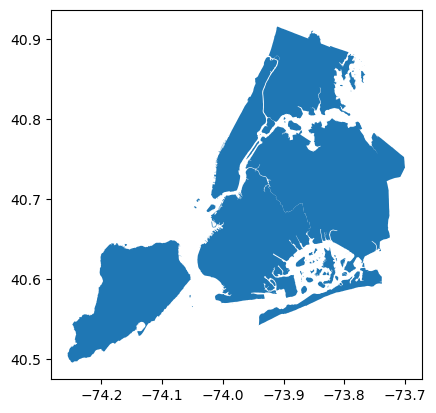

In [25]:
#Podemos obtener los poligonos que encierran la ciudad de Nueva York directamente desde la api
shapefile_url = "https://data.cityofnewyork.us/api/geospatial/7t3b-ywvw?method=export&format=Shapefile"
boroughs = gpd.read_file(shapefile_url)
boroughs.plot()

In [41]:
#filtrar los restaurantes que estan afuera de la ciudad
gdf_filtrado = gpd.sjoin(metadata_gdf, boroughs, op='within')
gdf_filtrado.shape

(24857, 13)

Despues de la filtracion nos quedamos con 24857 restaurantes. Podemos visualizar los restaurantes para comprender un poco la distribucion de estos

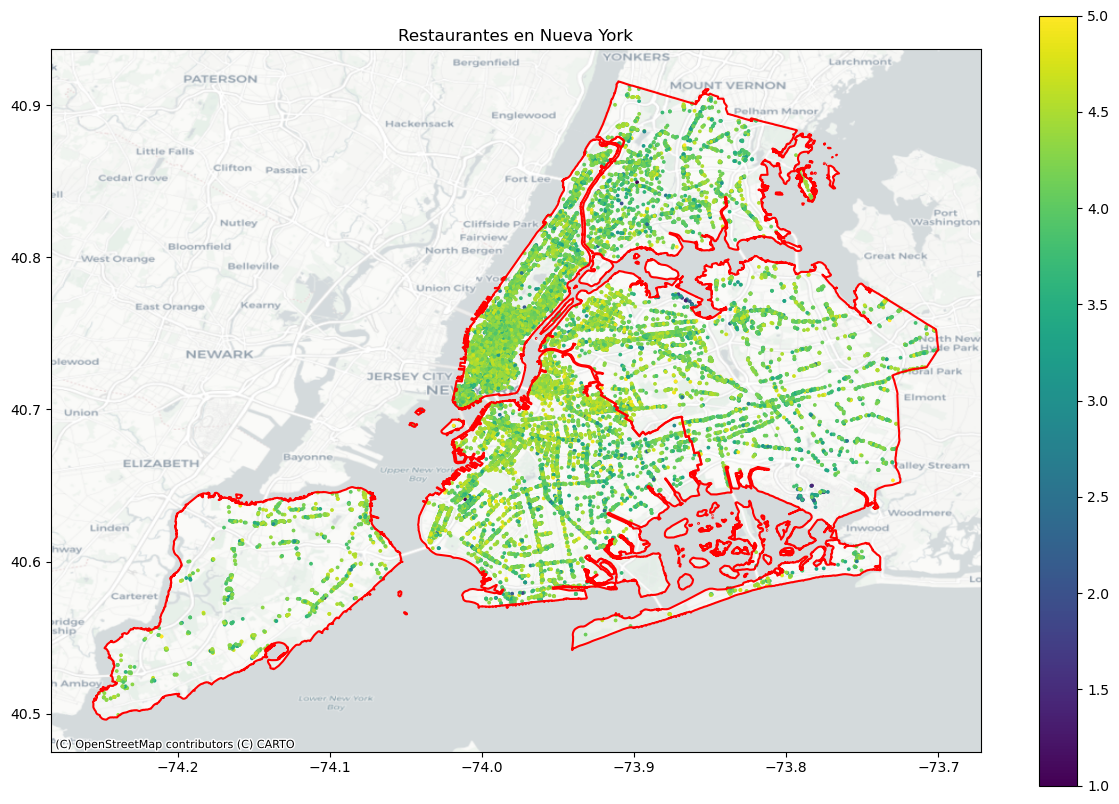

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf_filtrado.plot(column='avg_rating', ax=ax, legend=True, markersize=3) #el colorbar representara los ratings
boroughs.boundary.plot(ax=ax, color='red')
plt.title('Restaurantes en Nueva York')
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron) #se agrega el mapa base para obtener un sentido de la ciudad
plt.show()

Tambien se agregaron columnas despues de hacer el join con la data del mapa de Nueva York que no nos serviran.

In [43]:
gdf_filtrado.head(3)

,name,gmap_id,latitude,longitude,category,avg_rating,num_of_reviews,geometry,index_right,boro_code,boro_name,shape_leng,shape_area
42,Dunkin',0x89c261f60bdf13db:0x38da730e4687a97b,40.763985,-73.771430,"[Coffee shop, Bagel shop, Bakery, Breakfast re...",3.5,8,POINT (-73.77143 40.76399),4,4.0,Queens,888197.010944,3.041418e+09
238,李小龍台吃,0x89c289efdb82221b:0xed627c2af97c2069,40.770059,-73.735522,[Restaurant],4.0,27,POINT (-73.73552 40.77006),4,4.0,Queens,888197.010944,3.041418e+09
562,沈阳烧烤（Shen Yang Shao Kao BBQ）,0x89c261ea0a628bdf:0xf4f6d988c912587d,40.762806,-73.804747,"[Restaurant, Barbecue restaurant, Chinese rest...",4.6,165,POINT (-73.80475 40.76281),4,4.0,Queens,888197.010944,3.041418e+09


In [44]:
#eliminaresmos las ultimas 6 columnas que no nos aportaran al estudio
gdf_filtrado.drop(columns=['geometry', 'index_right', 'boro_code', 'boro_name', 'shape_leng', 'shape_area'], inplace=True)

In [45]:
gdf_filtrado.shape

(24857, 7)

### Ahora tenemos que filtrar.
Para ahorrarnos bastante tiempo y memoria, se puede leer la data en chunks y filtrar directamente en las reviews que sean sobre los restaurantes que vamos a trabajar.

In [46]:
chunksize = 10**5

chunks = pd.read_json('review-New_York_10.json.gz', lines=True, compression='gzip', chunksize=chunksize)

#funcion para filtrar por id de restaurante
def filtrar_reviews(chunk):
    return chunk[chunk['gmap_id'].isin(gdf_filtrado['gmap_id'])]

#se concatenan los chunks
reviews = pd.concat(filtrar_reviews(chunk) for chunk in chunks)

In [49]:
reviews.head(2)

,user_id,name,time,rating,text,pics,resp,gmap_id
147,1.018635e+20,Maria Patricia Londoño,1629077998394,4,The donuts is always a good place to buy somet...,None,None,0x89c261f60bdf13db:0x38da730e4687a97b
148,1.019546e+20,Kristal,1593616678555,5,I went into this Dunkin' yesterday and got som...,[{'url': ['https://lh5.googleusercontent.com/p...,None,0x89c261f60bdf13db:0x38da730e4687a97b


In [47]:
reviews.shape

(4088883, 8)

Tenemos que asegurarnos que no hayan nulos en las columnas mas importantes (user_id y rating) y tambien dropearemos las columnas que no se usaran.

In [52]:
#dropeamos nulos 
reviews.dropna(subset=['user_id', 'rating'], inplace=True)

#dropeamos las columnas que no se usaran 
reviews.drop(columns=['time', 'text', 'pics', 'resp'], inplace=True)

#hay que asegurarse que no hayan reviews repetidas 
reviews.drop_duplicates(subset=['user_id', 'gmap_id'], inplace=True)

In [53]:
reviews.isna().sum()

user_id    0
name       0
rating     0
gmap_id    0
dtype: int64

In [54]:
reviews.shape

(4037256, 4)

Nos quedamos con 4037256 reviews y sin nulos ni duplicados.

### Ahora tenemos que exportar los datos.
Vamos a usar el formato .feather para llevar a cabo la exportacion ya que de esta forma los archivos pesaran bastante menos y seran mas eficientes para trabajar.

In [55]:
#reseteamos el index
gdf_filtrado.reset_index(drop=True, inplace=True)
reviews.reset_index(drop=True, inplace=True)

In [56]:
gdf_filtrado.to_feather('metadata.feather')
reviews.to_feather('reviews.feather')

Una vez exportados los datos, se pueden trabajar en otro jupyter.